# Drizzle 2a: Bayer drizzle

#### This is the same code as in the Drizzle 2 script, but augmented with super resolution handling.

Drizzle separately each of the R, G, and B arrays of a Bayer image. 

At the end, combine the resulting 3 arrays as a 3-extension FITS file. 

It is assumed the input was already background-subtracted.

Originally this notebook was developed with the ISO 12800 data set as the test data. In the current version, it is configured to use the ISO 6400 data set. Statements specific to the original data set were comented out.

In [1]:
# %matplotlib ipympl

import os, glob
import datetime

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from drizzle import cdrizzle
import rawpy

from datapath import DATA

# IMAGE_SUFFIX = ".cutout.fits"         # 135 mm
IMAGE_SUFFIX = ".bkg_subtracted.fits"   # 85 mm
# IMAGE_SUFFIX = ".ARW"   # 85 mm
# PIXFRAC = 0.5
PIXFRAC = 1.0

# default is no super-resolution. Make this True to enable super-resolution
super_resolution = True

# for background subtraction experiment
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
from astropy.stats import SigmaClip
from photutils import Background2D, MedianBackground, ModeEstimatorBackground

/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_26347/938246381.py:33: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground
/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_26347/938246381.py:33: DeprecationWarning: `photutils.MedianBackground` is a deprecated alias for `photutils.background.MedianBackground` and will be removed in the future. Instead, please use `from photutils.background import MedianBackground` to silence this warning.
  from photutils import Background2D, MedianBackground, ModeEstimatorBackground
/var/folders/y5/zcwj7zc17g19nggvb1vx4rc80000gn/T/ipykernel_26347/938246381.py:33: DeprecationWarning: `photutils.ModeEstimatorBackground` is a deprecated alias for `photutils.background.ModeEsti

## Functions

In [2]:
# input images can be either ARW or FITS (tipically, background-subtracted)

def _read_fits_image(image_name):
    f = fits.open(image_name)
    imarray = f[1].data
    f.close()
    return imarray

def _read_arw_image(image_name):
    raw = rawpy.imread(image_name)
    return raw.raw_image_visible.astype(float)

read_function = {
    "FITS": _read_fits_image,
    "ARW":  _read_arw_image
}

def read_image(image_name):
    imarray = read_function[image_name.split('.')[-1].upper()](image_name)
    
    if super_resolution:
        imarray = np.repeat(np.repeat(imarray, 2, axis=1), 2, axis=0)
        
    return imarray

In [3]:
# read offsets image. This function creates offsets arrays with size
# appropriate for the selected super-resolution.
def read_offsets(filename):
    fname_offsets = filename.replace(IMAGE_SUFFIX, ".offsets.fits")  

    f = fits.open(fname_offsets)
    offsets_x = f[1].data
    offsets_y = f[2].data
    f.close()
    
    if super_resolution:
        # offsets for super resolution array are generated from original offsets by 
        # adding intra-pixel offsets to each super-resolution pixel.

        # blow up offsets arrays to twice their size by duplicating offsets values
        offsets_x_two = np.repeat(np.repeat(offsets_x, 2, axis=1), 2, axis=0)
        offsets_y_two = np.repeat(np.repeat(offsets_y, 2, axis=1), 2, axis=0)

        # offset values in the super resolution array are twice as much as 
        # offset values in the original image
        offsets_x_two *= 2.
        offsets_y_two *= 2.

        # but each individual offset in each of the 2x2 cells in the duplicated array, 
        # must be corrected by an intra-pixel offset.
        _x = [-0.5, 0.5]   # row array
        intrapixel_offsets_x = np.tile(_x, (offsets_x_two.shape[0], offsets_x.shape[1]))
        _y = [[-0.5], [0.5]]   # column array
        intrapixel_offsets_y = np.tile(_y, (offsets_y.shape[0], offsets_y_two.shape[1]))

        # add intra_pixel offsets to original, expanded offsets
        offsets_x_two += intrapixel_offsets_x
        offsets_y_two += intrapixel_offsets_y
        
        offsets_x = offsets_x_two
        offsets_y = offsets_y_two
        
    return (offsets_x, offsets_y)

In [4]:
def drizz_rgb(imarray, pixmap, output_array, weights, output_counts, output_context, 
              aslice=None):
    # for diagnostic purposes, this function will also return stats associated 
    # with each one of the input RGB arrays
    stats = []
    
    # loop over the RGB bands    
    for band in list(range(3)):
        
        # generate zeroed array and add the input rawpy array to it. This is necessary 
        # since calling cdrizzle.tdriz directly with the rawpy-generated array as input,
        # causes an exception to be raised by cdrizzle. 
        # 
        # We also need to apply the mask/weights here, because drizzle will re-scale 
        # the mask when doing pixel re-scaling.
        imarray_copy = np.zeros(imarray.shape, dtype='float32')
        imarray_copy += imarray * weights[band]

        # stats for diagnostics
        imarray_stats = imarray_copy
        imarray_stats[imarray_copy == 0.] = np.NaN
        stats.append(np.nanmean(imarray_stats[aslice]))
        
        # call C core drizzle algorithm
        cdrizzle.tdriz(imarray_copy, weights[band], pixmap, output_array[band], 
                       output_counts[band], output_context[band], 
                       kernel="turbo", expscale=1., pixfrac=PIXFRAC)
        
    return stats

In [5]:
def drizz(filename, output_array, weights, output_counts, output_context):
    '''
    Drizzle one raw image. 
    
    This works by breaking up the raw array into each one of its 3 sub-images,
    R, G, and B, and drizzling them separately into their own respective
    output arrays. A single pixel mapping file containing the offsets associated 
    with the input raw image is used. This is the file created by the Offsets_X 
    scripts.
    
    The outputs are 3-tuples that store respectively the R, G, and B results 
    in each one of their elements. They have to be allocated and initialized
    by the caller.
    
    The weights array must have the RGB pixel masks multiplied into them.
    '''
    # read input image, and its offsets. Offset super resolution 
    # is handled by the reader function
    imarray = read_image(filename)
    offsets_x, offsets_y = read_offsets(filename)
    
    # offsets are divided by PIXFRAC to account for larger
    # distances in the output subsampled array.
#     offsets_x /= PIXFRAC
#     offsets_y /= PIXFRAC
    
    # build 1-to-1 pixmap
    idxmap = np.indices((imarray.shape[1], imarray.shape[0]), dtype='float64')

    # add offsets
    idxmap[0] -= offsets_x.transpose()
    idxmap[1] -= offsets_y.transpose()

    # reshape for drizzle
    idxmap = idxmap.transpose()
    idxmap = idxmap.reshape(imarray.shape[1] * imarray.shape[0], 2)
    pixmap = idxmap.reshape(imarray.shape[0], imarray.shape[1], 2)
    
    # call drizzle on the RGB arrays
    yr0 = 0
    yr1 = reference_imarray.shape[0]
    xr0 = 0
    xr1 = reference_imarray.shape[1]

    aslice = np.index_exp[yr0:yr1,xr0:xr1]

    stats = drizz_rgb(imarray, pixmap, output_array, weights, output_counts, output_context,
                          aslice=aslice)
    
    # print stats
    _, fname = os.path.split(fpath)
    print(fname, stats)

## Read reference image

In [6]:
# reference image used in the Offsets_X scripts. Offsets are defined against this image.
# This reference is used for both the ISO 12800 and 6400 data sets.
# datadir = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')
# reference_fname = os.path.join(datadir,'DSC03770.ARW')

# reference for the Andromeda_2022 data set
datadir = os.path.join(DATA,'astrophotography_data/Andromeda_2022/104p105/')
reference_fname = os.path.join(datadir,"ADSC09939" + IMAGE_SUFFIX) 
reference_fname_arw = os.path.join(datadir,'DSC09939.ARW')

reference_imarray = read_image(reference_fname)

raw = rawpy.imread(reference_fname_arw)

## Build masks that isolate the R, G, and B layers from a Bayer array

This step must run only after an actual image was read by rawpy, so the Bayer encoding of said image becomes available.

In [7]:
# Bayer code mask should be the same size as input image
yr0 = 0
yr1 = reference_imarray.shape[0]
xr0 = 0
xr1 = reference_imarray.shape[1]

bayer_slice = np.index_exp[yr0:yr1,xr0:xr1]
bayer_slice

(slice(0, 5696, None), slice(0, 8512, None))

In [8]:
colors_array = raw.raw_colors_visible

red_mask = np.where(colors_array == 0, 1, 0).astype(np.float32)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = (green_mask_1 | green_mask_2).astype(np.float32)

blue_mask = np.where(colors_array == 2, 1, 0).astype(np.float32)

if super_resolution:
    red_mask   = np.repeat(np.repeat(red_mask,   2, axis=1), 2, axis=0)
    green_mask = np.repeat(np.repeat(green_mask, 2, axis=1), 2, axis=0)
    blue_mask  = np.repeat(np.repeat(blue_mask,  2, axis=1), 2, axis=0)

masks = []
masks.append(red_mask)
masks.append(green_mask)
masks.append(blue_mask)

## Define list of images to be processed

In [9]:
# path1 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light')   # ISO 12800 data set
# path2 = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/6400/light')   # ISO 6400 data set

# list_p_1 = glob.glob(path1 + '/*.ARW')[1:]
# list_p_2 = glob.glob(path2 + '/*.ARW')
# list_p = list_p_2[20:] + list_p_1

# list_r = [reference_fname]

# list_p.sort()
# list_p.reverse()
# list_p = list_r + list_p


# Andromeda_2022 data set
list_p = glob.glob(datadir + "/*" + IMAGE_SUFFIX)
list_p.sort()
list_p = list_p[1:]

## Allocate and initialize arrays used by drizzle

Use Bayer masks as weights for drizzling.

In [10]:
weights = []
output_array = []
output_counts = []
output_context = []

array_shape0 = int(reference_imarray.shape[0] / PIXFRAC)
array_shape1 = int(reference_imarray.shape[1] / PIXFRAC)
output_shape = (array_shape0, array_shape1)

for band in list(range(3)):

    weights.append(np.ones(reference_imarray.shape, dtype='float32') * masks[band])

    output_array.append(np.zeros(output_shape, dtype='float32'))
    output_counts.append(np.zeros(output_shape, dtype='float32'))
    output_context.append(np.zeros(output_shape, dtype='int32'))

## Loop over list of images

In [11]:
# for fpath in list_p[0:5]:
for fpath in list_p:
    drizz(fpath, output_array, weights, output_counts, output_context)

ADSC09940.bkg_subtracted.fits [1.5459398, 0.9355241, -0.4723798]
ADSC09941.bkg_subtracted.fits [1.5502092, 0.91578233, -0.53384006]
ADSC09942.bkg_subtracted.fits [1.5680088, 0.9728283, -0.4856238]
ADSC09943.bkg_subtracted.fits [1.5377611, 0.9504957, -0.489013]
ADSC09944.bkg_subtracted.fits [1.5471356, 0.9721795, -0.49222702]
ADSC09945.bkg_subtracted.fits [1.5243328, 0.94350326, -0.4917909]
ADSC09946.bkg_subtracted.fits [1.5519961, 0.91760427, -0.52355987]
ADSC09947.bkg_subtracted.fits [1.5086766, 0.8901388, -0.5105248]
ADSC09948.bkg_subtracted.fits [1.5348297, 0.9359766, -0.4833741]
ADSC09949.bkg_subtracted.fits [1.5217073, 0.93455213, -0.48458686]
ADSC09950.bkg_subtracted.fits [1.575664, 0.947542, -0.45165396]
ADSC09951.bkg_subtracted.fits [1.516933, 0.9553678, -0.4443324]
ADSC09952.bkg_subtracted.fits [1.5316361, 0.9412829, -0.46779853]
ADSC09953.bkg_subtracted.fits [1.4992359, 0.9246019, -0.4944316]
ADSC09954.bkg_subtracted.fits [1.517817, 0.9176882, -0.49869922]
ADSC09955.bkg_subtr

BADSC00066.bkg_subtracted.fits [1.4053874, 1.231686, -0.14428459]
BADSC00067.bkg_subtracted.fits [1.4282463, 1.2305541, -0.13221711]
BADSC00068.bkg_subtracted.fits [1.3897166, 1.1920822, -0.15195327]
BADSC00069.bkg_subtracted.fits [1.4159018, 1.2547163, -0.1059164]
BADSC00070.bkg_subtracted.fits [1.3861364, 1.2549036, -0.12878239]
BADSC00071.bkg_subtracted.fits [1.4019916, 1.2423135, -0.16519716]
BADSC00072.bkg_subtracted.fits [1.4168445, 1.1958667, -0.13910729]
BADSC00073.bkg_subtracted.fits [1.4236915, 1.219485, -0.12207584]
BADSC00074.bkg_subtracted.fits [1.4371496, 1.1987435, -0.13693172]
BADSC00075.bkg_subtracted.fits [1.4550831, 1.2147145, -0.15682517]
BADSC00076.bkg_subtracted.fits [1.436271, 1.2715172, -0.113547705]
BADSC00077.bkg_subtracted.fits [1.4335374, 1.2339017, -0.11965339]
BADSC00078.bkg_subtracted.fits [1.4138004, 1.2324121, -0.115632325]
BADSC00079.bkg_subtracted.fits [1.4476277, 1.227799, -0.10978945]
BADSC00080.bkg_subtracted.fits [1.4075601, 1.2199011, -0.17821886

In [12]:
coadded_r = output_array[0]
coadded_g = output_array[1]
coadded_b = output_array[2]

In [13]:
print(np.mean(coadded_r))
print(np.mean(coadded_g))
print(np.mean(coadded_b))

1.3628854
0.5904022
-1.1186887


## Write FITS with result

In [14]:
# Build 3-extension FITS file with R,G,B drizzled arrays in separate HDUs 
today = datetime.datetime.now().ctime()
drizz_name = os.path.join(datadir, 'drizzle.fits')
print(drizz_name, today)

hdr = fits.Header()
hdr['DATE'] = today
hdr['PATH'] = drizz_name
primary_hdu = fits.PrimaryHDU(header=hdr)

red_hdu   = fits.ImageHDU(coadded_r.astype('float32'))
green_hdu = fits.ImageHDU(coadded_g.astype('float32'))
blue_hdu  = fits.ImageHDU(coadded_b.astype('float32'))

red_hdu.header['BAND'] = 'RED'
green_hdu.header['BAND'] = 'GREEN'
blue_hdu.header['BAND'] = 'BLUE'

hdul = fits.HDUList([primary_hdu, red_hdu, green_hdu, blue_hdu])
hdul.writeto(drizz_name, overwrite=True)

/Volumes/PortableSSD/backup/Projects/astrophotography_data/Andromeda_2022/104p105/drizzle.fits Mon Aug  5 14:27:02 2024


## Plot diagnostics

In [15]:
hdul = fits.open(drizz_name)
coadded_r = hdul[1].data
coadded_g = hdul[2].data
coadded_b = hdul[3].data

In [16]:
# aslice = np.index_exp[1100:1290,1900:2100]
# aslice = np.index_exp[800:1800,2200:3200]
# aslice = np.index_exp[1150:1350,2250:2440]
# aslice = np.index_exp[1050:1250,2750:2950] # M31
aslice = np.index_exp[0:coadded_r.shape[0], 0:coadded_r.shape[1]] # Andromeda_2022
# aslice = np.index_exp[700:800,1250:1300] # Andromeda_2022

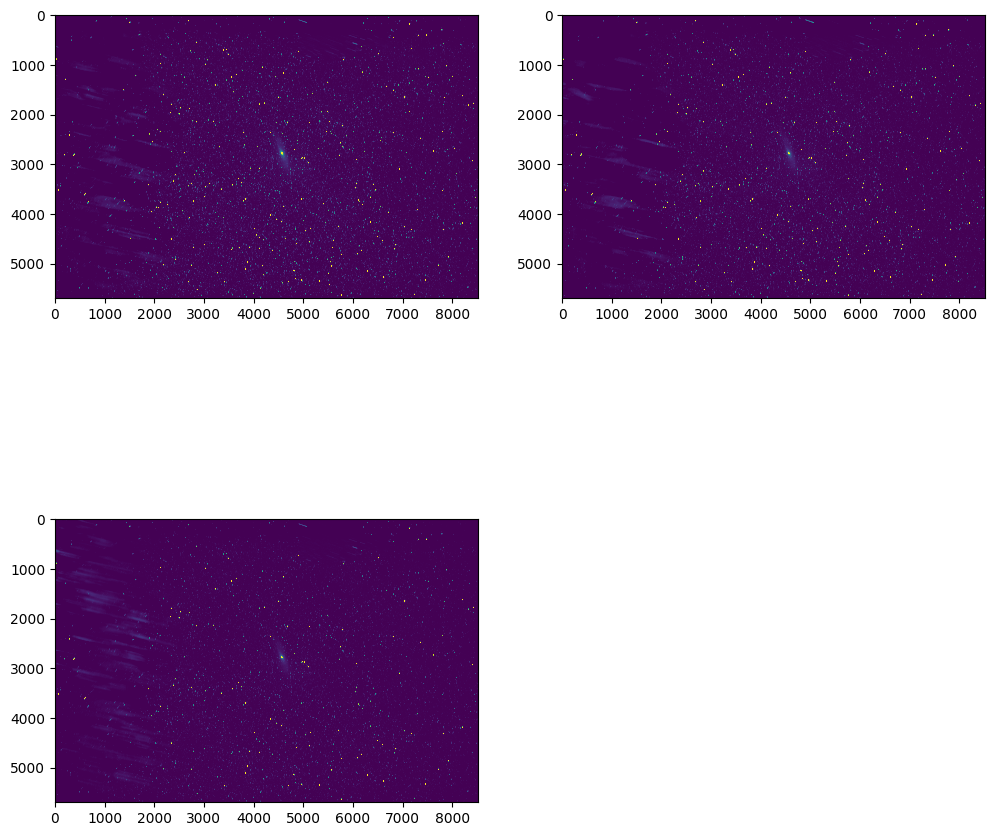

In [17]:
vmax = 200

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(2, 2, 1)
plt.imshow(coadded_g[aslice], vmin=0, vmax=vmax)
ax1 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.imshow(coadded_b[aslice], vmin=0, vmax=vmax)
ax2 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.imshow(coadded_r[aslice], vmin=0, vmax=vmax)

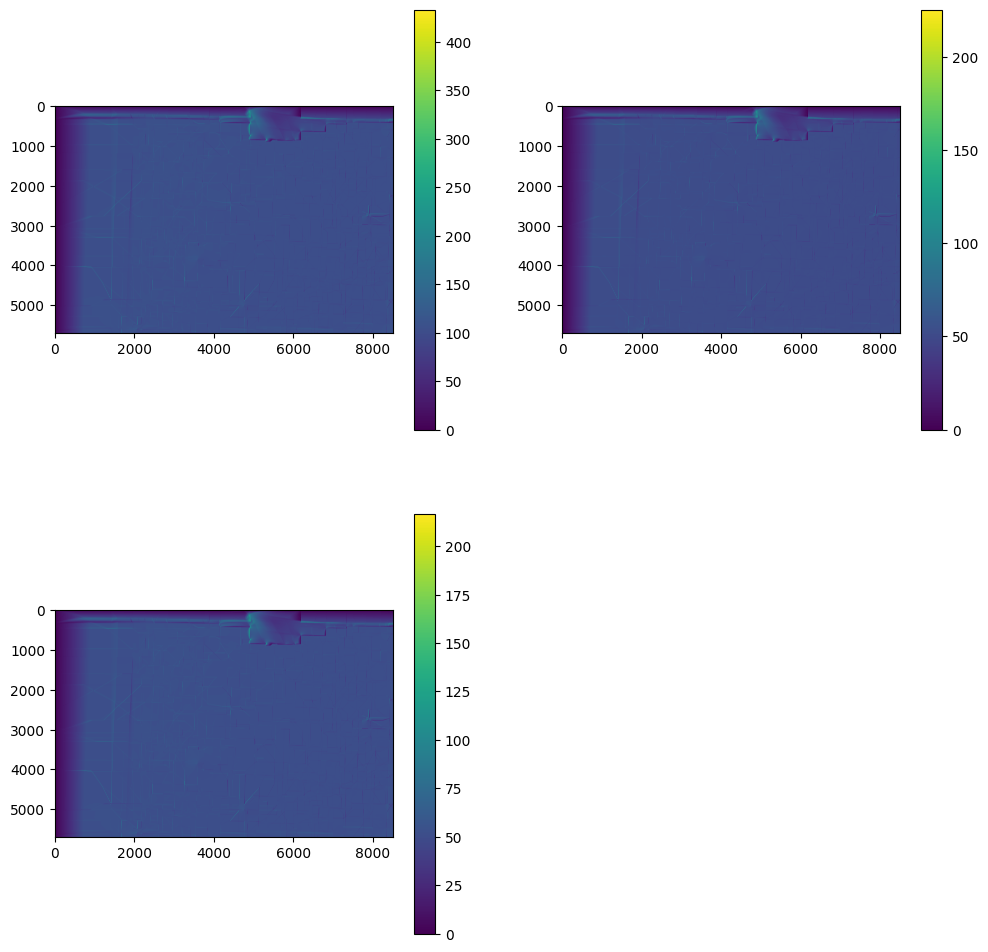

In [18]:
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(2, 2, 1)
plt.imshow(output_counts[1][aslice])
plt.colorbar()
ax1 = fig.add_subplot(2, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_counts[2][aslice])
plt.colorbar()
ax2 = fig.add_subplot(2, 2, 3, sharex=ax, sharey=ax)
plt.imshow(output_counts[0][aslice])
plt.colorbar()

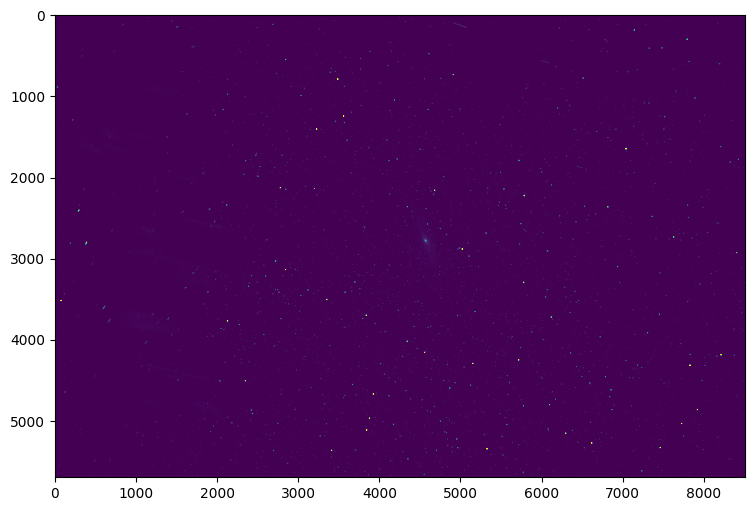

In [19]:
test_image = coadded_r * 1.93 + coadded_g + coadded_b * 1.90

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(test_image[aslice], vmin=0, vmax=5000)

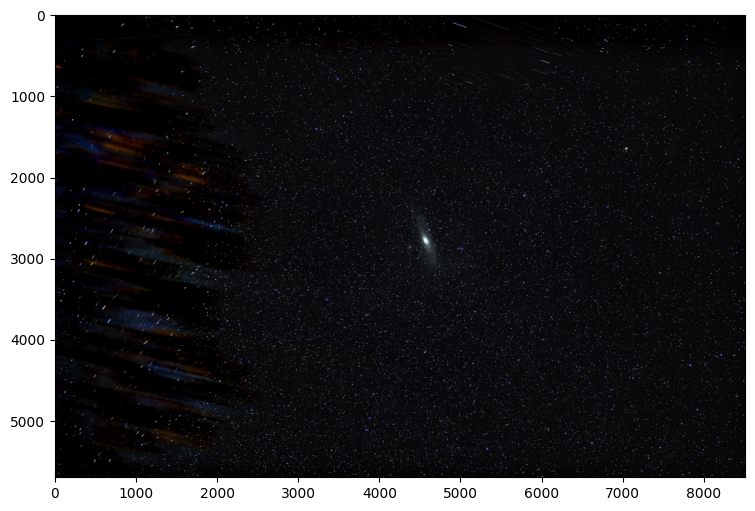

In [20]:
rgb_image = make_lupton_rgb(coadded_r * 1.5, coadded_g, coadded_b * 1.5, Q=1., stretch=150., minimum=-5.)

fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb_image[aslice])

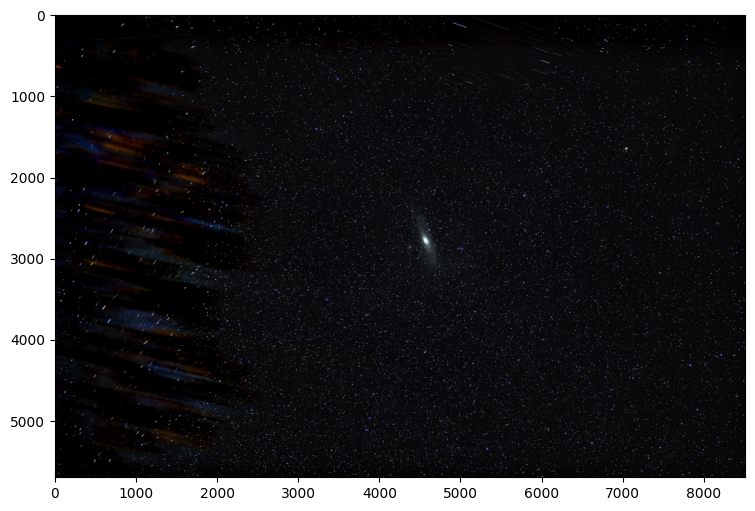

In [21]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(rgb_image)

In [22]:
rgb_image.shape

(5696, 8512, 3)

In [23]:
plt.imsave("drizzle.tiff", rgb_image)

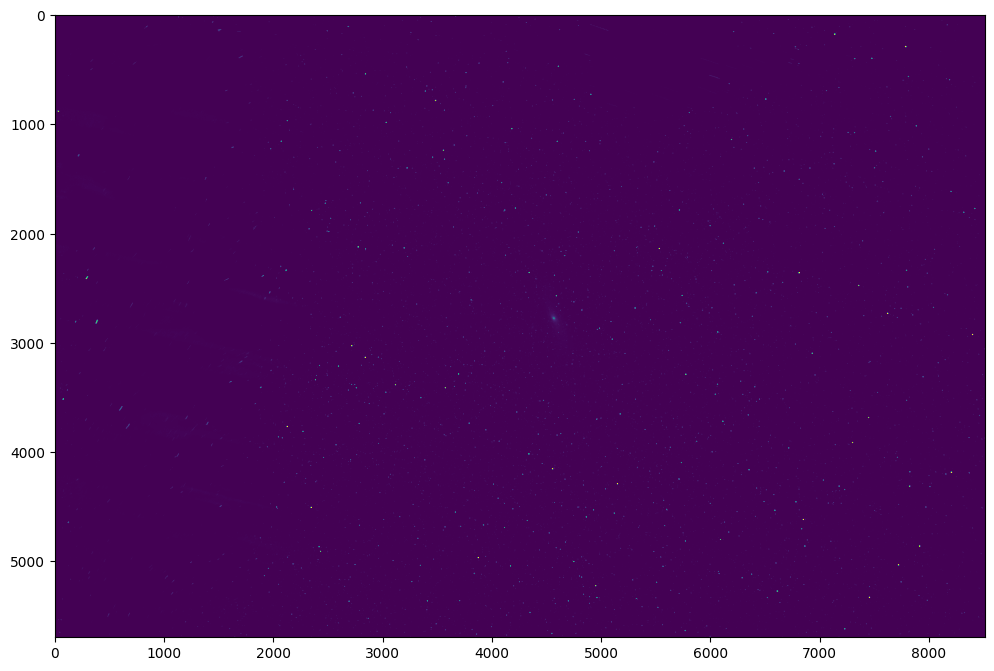

In [24]:
test = coadded_g - coadded_r

vmax = 1000

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
plt.imshow(test[aslice], vmin=0, vmax=vmax)